## Description:
这个jupyter是建立Deep Crossing模型并完成训练， 这个模型结构相对来说比较简单， 我们可以看一下结构：

![](img/1.png)
下面尝试用Pytorch建立这个模型， 并使用Pytorch完成模型的训练和测试， 一方面对这个结构有个更深的认识， 另一方面也可以把Pytorch的知识应用起来。关于Pytorch的建模流程， 主要有四步：
1. 准备数据
2. 建立模型
3. 训练模型
4. 使用和保存

基于之前学习的Pytorch知识， 利用这个机会把这些都串一下。 

## 导入包和数据

In [15]:
# 导入必要的库
import datetime
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [16]:
# 加载数据
train_set = pd.read_csv('preprocessed_data/train_set.csv')
val_set = pd.read_csv('preprocessed_data/val_set.csv')
test_set = pd.read_csv('preprocessed_data/test.csv')

# 显示数据的前几行
train_set.head()

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,Label
0,0.094737,0.000381,0.000828,0.080460,0.000121,0.001509,0.005428,0.009141,0.001242,0.25,...,188,23,2,1033,0,0,67,27,425,0
1,0.000000,0.000254,0.000709,0.045977,0.007090,0.019836,0.003016,0.007313,0.053752,0.00,...,285,65,2,294,0,0,175,21,150,0
2,0.000000,0.000127,0.000236,0.034483,0.005945,0.000647,0.001206,0.005484,0.000532,0.00,...,188,23,3,700,0,1,250,27,303,0
3,0.000000,0.001144,0.003784,0.264368,0.031171,0.008840,0.009047,0.025594,0.004258,0.00,...,2,23,1,638,0,1,67,27,410,0
4,0.000000,0.011823,0.000118,0.195402,0.006079,0.099828,0.011460,0.054845,0.079652,0.00,...,16,23,1,1090,0,0,458,4,91,0


In [17]:
# 数据探索与分析
print("训练集大小:", train_set.shape)
print("验证集大小:", val_set.shape)
print("测试集大小:", test_set.shape)

# 查看数据的统计信息
train_set.describe()

训练集大小: (1279, 40)
验证集大小: (320, 40)
测试集大小: (400, 39)


,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C18,C19,C20,C21,C22,C23,C24,C25,C26,Label
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,...,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,0.022016,0.015944,0.003450,0.073019,0.012705,0.025402,0.007889,0.024881,0.021041,0.081314,...,262.008600,26.526192,1.006255,577.075841,0.655981,2.086005,336.782643,8.593432,146.248632,0.219703
std,0.082361,0.057635,0.030786,0.108127,0.048028,0.065250,0.033551,0.036136,0.042033,0.139284,...,150.047913,44.208611,1.143790,368.275709,1.472394,3.157887,213.861274,11.770982,181.231013,0.414207
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000254,0.000118,0.000000,0.000142,0.000000,0.000000,0.003656,0.001242,0.000000,...,143.000000,0.000000,0.000000,249.500000,0.000000,0.000000,163.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000636,0.000355,0.034483,0.001859,0.003881,0.001206,0.014625,0.006919,0.000000,...,257.000000,7.000000,1.000000,585.000000,0.000000,1.000000,317.000000,1.000000,17.000000,0.000000
75%,0.010526,0.005594,0.001537,0.091954,0.008928,0.020483,0.006031,0.038391,0.021998,0.250000,...,387.000000,23.000000,2.000000,903.000000,0.000000,2.000000,531.000000,24.000000,317.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.680466,1.000000,0.822669,0.600852,1.000000,...,533.000000,200.000000,3.000000,1203.000000,5.000000,11.000000,725.000000,32.000000,552.000000,1.000000


In [18]:
# 数据预处理
data_df = pd.concat((train_set, val_set, test_set))
dense_feas = ['I'+str(i) for i in range(1, 14)]
sparse_feas = ['C'+str(i) for i in range(1, 27)]

sparse_feas_map = {key: data_df[key].nunique() for key in sparse_feas}
feature_info = [dense_feas, sparse_feas, sparse_feas_map]

# 构建数据管道
dl_train_dataset = TensorDataset(
    torch.tensor(train_set.drop(columns='Label').values).float(), 
    torch.tensor(train_set['Label'].values).float().reshape(-1, 1)
)
dl_val_dataset = TensorDataset(
    torch.tensor(val_set.drop(columns='Label').values).float(), 
    torch.tensor(val_set['Label'].values).float().reshape(-1, 1)
)

dl_train = DataLoader(dl_train_dataset, shuffle=True, batch_size=16)
dl_valid = DataLoader(dl_val_dataset, shuffle=True, batch_size=16)

In [19]:
# 定义残差块
class Residual_block(nn.Module):
    def __init__(self, hidden_unit, dim_stack):
        super(Residual_block, self).__init__()
        self.linear1 = nn.Linear(dim_stack, hidden_unit)
        self.linear2 = nn.Linear(hidden_unit, dim_stack)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        orig_x = x.clone()
        x = self.linear1(x)
        x = self.linear2(x)
        outputs = self.relu(x + orig_x)
        return outputs

# 定义 DeepCrossing 模型
class DeepCrossing(nn.Module):
    def __init__(self, feature_info, hidden_units, dropout=0., embed_dim=10, output_dim=1):
        super(DeepCrossing, self).__init__()
        self.dense_feas, self.sparse_feas, self.sparse_feas_map = feature_info
        
        self.embed_layers = nn.ModuleDict({
            'embed_' + str(key): nn.Embedding(num_embeddings=val, embedding_dim=embed_dim)
            for key, val in self.sparse_feas_map.items()
        })
        
        embed_dim_sum = sum([embed_dim]*len(self.sparse_feas))
        dim_stack = len(self.dense_feas) + embed_dim_sum
        
        self.res_layers = nn.ModuleList([
            Residual_block(unit, dim_stack) for unit in hidden_units
        ])
        
        self.res_dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(dim_stack, output_dim)
    
    def forward(self, x):
        dense_inputs, sparse_inputs = x[:, :13], x[:, 13:]
        sparse_inputs = sparse_inputs.long()
        sparse_embeds = [self.embed_layers['embed_'+key](sparse_inputs[:, i]) 
                        for key, i in zip(self.sparse_feas_map.keys(), range(sparse_inputs.shape[1]))]   
        sparse_embed = torch.cat(sparse_embeds, axis=-1)
        stack = torch.cat([sparse_embed, dense_inputs], axis=-1)
        r = stack
        for res in self.res_layers:
            r = res(r)
        
        r = self.res_dropout(r)
        outputs = F.sigmoid(self.linear(r))
        return outputs

In [26]:
# 定义训练函数
def train_model(net, dl_train, dl_valid, optimizer, loss_func, metric_func, epochs=20, log_step_freq=10):
    metric_name = 'auc'
    dfhistory = pd.DataFrame(columns=["epoch", "loss", metric_name, "val_loss", "val_"+metric_name])
    print('Start Training...')
    nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print('========='*8 + "%s" %nowtime)

    for epoch in range(1, epochs+1):
        net.train()
        loss_sum = 0.0
        metric_sum = 0.0
        step = 1
        
        for step, (features, labels) in enumerate(dl_train, 1):
            optimizer.zero_grad()
            predictions = net(features)
            loss = loss_func(predictions, labels)
            try:
                metric = metric_func(predictions, labels)
            except ValueError:
                continue
            
            loss.backward()
            optimizer.step()
            
            loss_sum += loss.item()
            metric_sum += metric
            if step % log_step_freq == 0:
                print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                      (step, loss_sum/step, metric_sum/step))
        
        net.eval()
        val_loss_sum = 0.0
        val_metric_sum = 0.0
        val_step = 1
        
        for val_step, (features, labels) in enumerate(dl_valid, 1):
            with torch.no_grad():
                predictions = net(features)
                val_loss = loss_func(predictions, labels)
                try:
                    val_metric = metric_func(predictions, labels)
                except ValueError:
                    continue
            val_loss_sum += val_loss.item()
            val_metric_sum += val_metric
        
        info = (epoch, loss_sum/step, metric_sum/step, 
                val_loss_sum/val_step, val_metric_sum/val_step)
        dfhistory.loc[epoch-1] = info
        
        print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + 
              "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
              %info)
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print("\n"+"==========="*8 + "%s"%nowtime)
            
    print('Finished Training...')
    return dfhistory

# 初始化模型
hidden_units = [256, 128, 64, 32]
net = DeepCrossing(feature_info, hidden_units)

# 定义损失函数和优化器
def auc(y_pred, y_true):
    pred = y_pred.data.cpu().numpy()
    y = y_true.data.cpu().numpy()
    return roc_auc_score(y, pred)

loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)

# 训练模型
history = train_model(net, dl_train, dl_valid, optimizer, loss_func, auc)

Start Training...
========================================================================2025-01-21 20:25:19
[step = 10] loss: 0.541, auc: 0.582
[step = 20] loss: 0.566, auc: 0.605
[step = 30] loss: 0.535, auc: nan
[step = 40] loss: 0.515, auc: nan
[step = 50] loss: 0.531, auc: nan
[step = 60] loss: 0.534, auc: nan
[step = 70] loss: 0.531, auc: nan
[step = 80] loss: 0.530, auc: nan

EPOCH = 1, loss = 0.530,auc  = nan, val_loss = 0.442, val_auc = nan

========================================================================================2025-01-21 20:25:19
[step = 10] loss: 0.477, auc: 0.800
[step = 20] loss: 0.465, auc: 0.824
[step = 30] loss: 0.438, auc: 0.830
[step = 40] loss: 0.454, auc: 0.801
[step = 50] loss: 0.447, auc: 0.800
[step = 60] loss: 0.437, auc: 0.801
[step = 70] loss: 0.434, auc: 0.793
[step = 80] loss: 0.434, auc: 0.779

EPOCH = 2, loss = 0.434,auc  = 0.779, val_loss = 0.429, val_auc = 0.654

==========================================================================

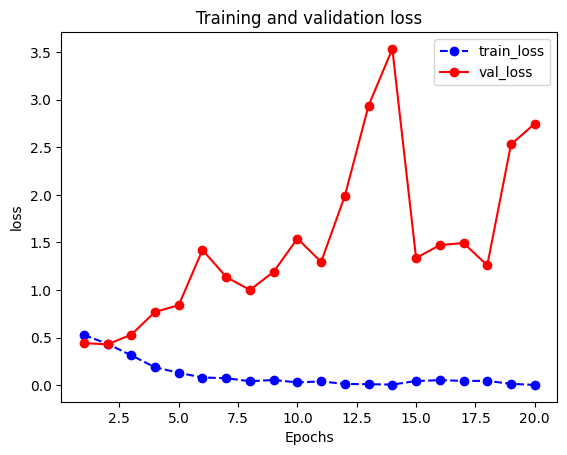

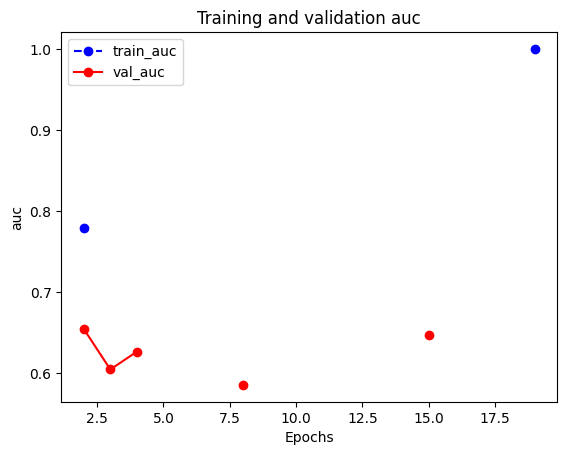

In [27]:
# 评估模型
import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

# 绘制损失和AUC曲线
plot_metric(history, "loss")
plot_metric(history, "auc")

In [22]:
# 保存模型
torch.save(net.state_dict(), './model/deep_crossing_model.pth')

测试集的列名: ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26']

预测为正例(1)的数据:
总共有 50 条正例数据

前5条正例数据示例:
          I1        I2        I3        I4        I5        I6        I7  \
2   0.000000  0.000254  0.000236  0.149425  0.002860  0.022423  0.000603   
8   0.000000  0.000254  0.002956  0.425287  0.001478  0.014661  0.000603   
9   0.000000  0.003305  0.000473  0.022989  0.002025  0.002587  0.003619   
12  0.021053  0.004068  0.003193  0.022989  0.000000  0.000000  0.001206   
19  0.000000  0.000509  0.009696  0.149425  0.007839  0.018974  0.010253   

          I8        I9   I10  ...  C18  C19  C20   C21  C22  C23  C24  C25  \
2   0.005484  0.017740  0.00  ...  392  117    2   125    3    0  175    2   
8   0.065814  0.012063  0.00  ...  404   38    2   272    0    7  509   18   
9   0.

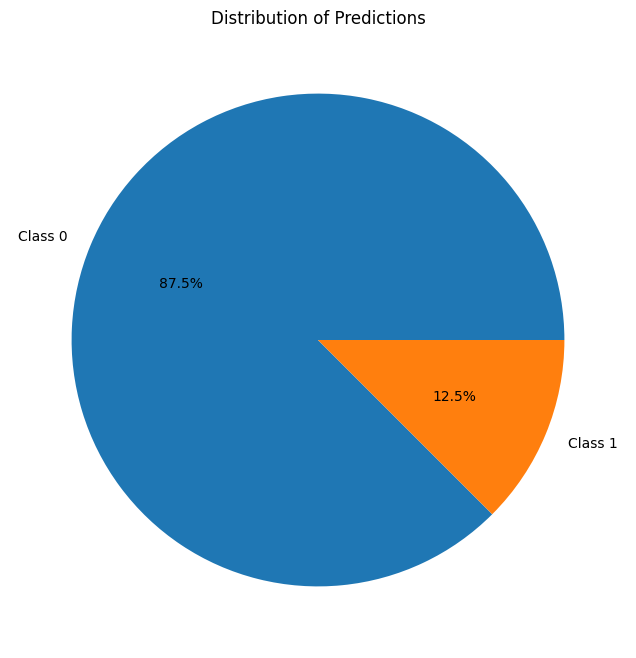

预测结果已保存到 predictions.csv


In [23]:
# 测试模型
# 加载测试数据
test_set = pd.read_csv('preprocessed_data/test.csv')

# 检查测试集的列名
print("测试集的列名:", test_set.columns.tolist())

# 如果测试集没有Label列，我们可以只用特征数据进行预测
test_dataset = TensorDataset(
    torch.tensor(test_set.values).float()  # 直接使用所有特征，不需要drop Label列
)
dl_test = DataLoader(test_dataset, shuffle=False, batch_size=16)

# 加载模型
net.load_state_dict(torch.load('./model/deep_crossing_model.pth'))
net.eval()

# 预测
y_pred_probs = []

with torch.no_grad():
    for features in dl_test:
        predictions = net(features[0])  # features是一个元组，需要取第一个元素
        y_pred_probs.extend(predictions.cpu().numpy())

# 将预测概率转换为二分类预测值
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

# 创建包含预测结果的DataFrame
test_set_with_pred = test_set.copy()
test_set_with_pred['predicted_label'] = y_pred

# 筛选出预测为1的数据
positive_predictions = test_set_with_pred[test_set_with_pred['predicted_label'] == 1]

print("\n预测为正例(1)的数据:")
print(f"总共有 {len(positive_predictions)} 条正例数据")
print("\n前5条正例数据示例:")
print(positive_predictions.head())

# 绘制预测值的饼图
plt.figure(figsize=(8, 8))
labels = ['Class 0', 'Class 1']
sizes = [y_pred.count(0), y_pred.count(1)]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Distribution of Predictions')
plt.show()

# 保存预测结果
predictions_df = pd.DataFrame({
    'prediction_prob': y_pred_probs,
    'prediction': y_pred
})
predictions_df.to_csv('predictions.csv', index=False)
print("预测结果已保存到 predictions.csv")